In [37]:
# Importando las librerias básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Código usado para importar datos a google colab
from google.colab import files
files.upload()

In [39]:
# Cargando el archivo importado, viendo las dos primeras instancias
# sus dimensiones y el tipo de datos que contiene
data_raw=pd.read_csv("heart.csv")
print("Las primeras instancias del dataset son:")
print(data_raw.head(5).to_string())
print("\n Las dimensiones del dataset son", data_raw.shape)
print("\n Los tipos de datos que incluye el dataset son", data_raw.shape)
print(data_raw.dtypes)
# Se verifico que la data era balanceada

Las primeras instancias del dataset son:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease
0   40   M           ATA        140          289          0     Normal    172              N      0.0       Up             0
1   49   F           NAP        160          180          0     Normal    156              N      1.0     Flat             1
2   37   M           ATA        130          283          0         ST     98              N      0.0       Up             0
3   48   F           ASY        138          214          0     Normal    108              Y      1.5     Flat             1
4   54   M           NAP        150          195          0     Normal    122              N      0.0       Up             0

 Las dimensiones del dataset son (918, 12)

 Los tipos de datos que incluye el dataset son (918, 12)
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cho

**Clasificación de las variables con las que se cuenta.**

---

Age            - Cuantitativa \\
Sex            - Dicotómica \\
ChestPainType  - Cualitativa \\
RestingBP      - Cuantitativa \\
Cholesterol    - Cuantitativa \\
FastingBS      - Dicotomica \\
RestingECG     - Cualitativa \\
MaxHR          - Cuantitativa \\
ExerciseAngina - Cualitativa \\
Oldpeak        - Cuantitativa \\
ST_Slope       - Cualitativa \\
HeartDisease   - Dicotómica

In [40]:
# Separammos las variables numericas de las no numericas
cols = data_raw.columns
num_cols = data_raw._get_numeric_data().columns
num_cols
cat_cols=list(set(cols) - set(num_cols))
print("Numerical features", num_cols)
print("Non-numerical features", cat_cols)

Numerical features Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease'],
      dtype='object')
Non-numerical features ['ExerciseAngina', 'Sex', 'RestingECG', 'ChestPainType', 'ST_Slope']


Numerical Data 
               Age   RestingBP  Cholesterol   FastingBS       MaxHR     Oldpeak  HeartDisease
count  918.000000  918.000000   918.000000  918.000000  918.000000  918.000000    918.000000
mean    53.510893  132.396514   198.799564    0.233115  136.809368    0.887364      0.553377
std      9.432617   18.514154   109.384145    0.423046   25.460334    1.066570      0.497414
min     28.000000    0.000000     0.000000    0.000000   60.000000   -2.600000      0.000000
25%     47.000000  120.000000   173.250000    0.000000  120.000000    0.000000      0.000000
50%     54.000000  130.000000   223.000000    0.000000  138.000000    0.600000      1.000000
75%     60.000000  140.000000   267.000000    0.000000  156.000000    1.500000      1.000000
max     77.000000  200.000000   603.000000    1.000000  202.000000    6.200000      1.000000 



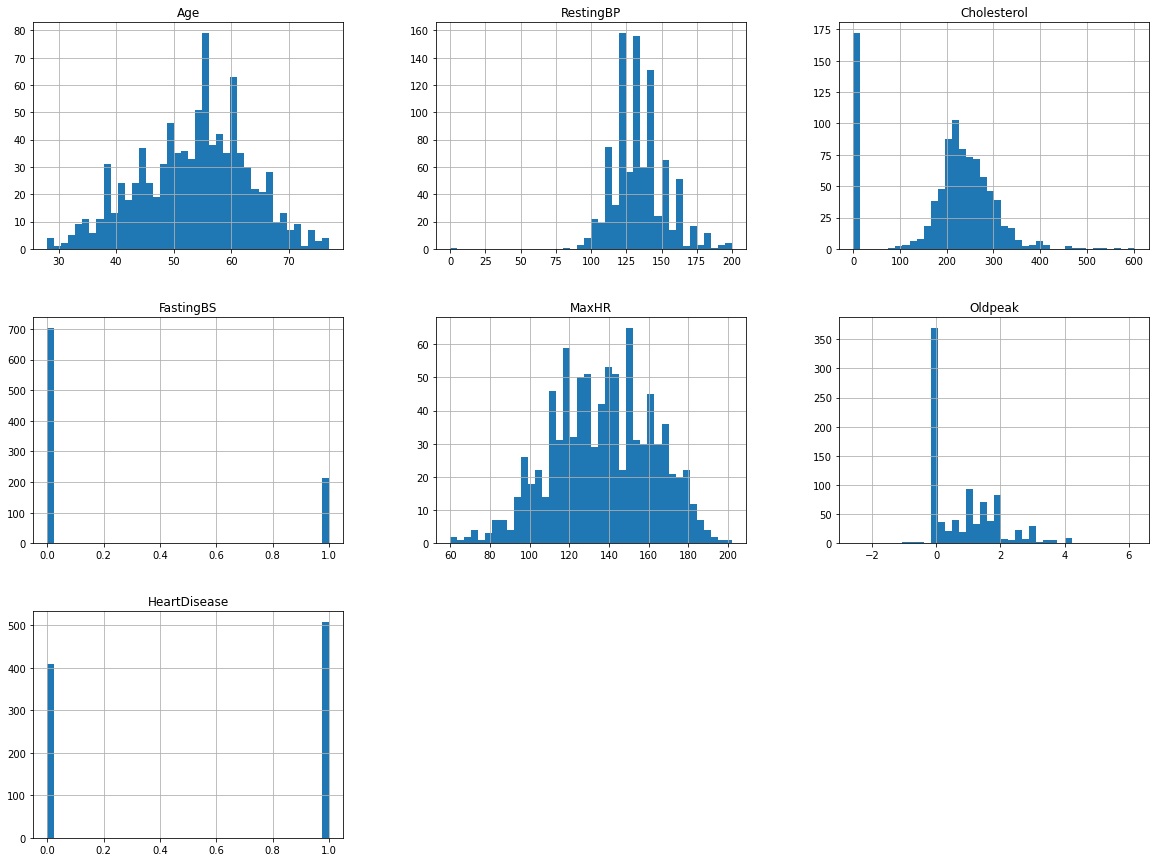

In [58]:
# Previsualización de variables numericas para ver distribuciones
# además obtenemos estadisticos de cada variable
data_raw[num_cols].hist(bins=40, figsize=(20,15))
print("Numerical Data \n", data_raw[num_cols].describe(include="all").to_string(), "\n" )

In [52]:
print("Non-Numerical Data \n", data_raw[cat_cols].describe(include="all").to_string(), "\n" )
# para la data no numerica obtenemes la frecuencia de valores comunes.
for i in range(len(cat_cols)):
  print(data_raw[cat_cols[i]].value_counts(), "\n")

Non-Numerical Data 
        ExerciseAngina  Sex RestingECG ChestPainType ST_Slope
count             918  918        918           918      918
unique              2    2          3             4        3
top                 N    M     Normal           ASY     Flat
freq              547  725        552           496      460 

N    547
Y    371
Name: ExerciseAngina, dtype: int64 

M    725
F    193
Name: Sex, dtype: int64 

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64 

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64 

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64 



In [61]:
# Realizamos un LabelEncoder para convertir las variables no numericas
# en numericas y poder trabajar con el algoritmo de RFC
df=data_raw.copy()
from sklearn.preprocessing import LabelEncoder
for c in df.columns:
    if df[c].dtype=='object':
        df[c] = df[c].fillna('NAN')
        lbl = LabelEncoder()
        lbl.fit(list(df[c].values))
        df[c] = lbl.transform(df[c].values)
df.head()
# Revisamos que se le asignaron valores enteros a las variables no numericas

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [66]:
# Como observamos anteriormente en los datos de colesterol se encontraba un grupo
# atípico así que revisaremos sus caracteristicas
print("El numero de valores diferentes en cholesterol menores de 70 es:", df[df['Cholesterol']<70]['Cholesterol'].nunique())
df[df['Cholesterol']<70].describe()
# Se encontró que los valores eran 0, no corresponden con valores reales por lo que 
# se asume que se trataron de valores perdidos.

# De igual forma en Oldpeak se encuentran algunos datos negativos que pueden
# ser eliminados
print("El numero de valores menores que 0 en Oldpeak es: ", df[df['Oldpeak']<0]['Oldpeak'].nunique())

El numero de valores diferentes en cholesterol menores de 70 es: 1
El numero de valores menores que 0 en Oldpeak es:  10


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000
mean,52.943089,0.756098,0.840108,133.111111,242.138211,0.166667,0.930894,140.239837,0.386179,0.906640,1.411924,0.475610
std,9.471489,0.429726,0.958524,17.322188,52.736022,0.372931,0.633180,24.620059,0.487203,1.075657,0.599384,0.499743
min,28.000000,0.000000,0.000000,92.000000,85.000000,0.000000,0.000000,69.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,1.000000,0.000000,120.000000,207.000000,0.000000,1.000000,122.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,1.000000,130.000000,237.000000,0.000000,1.000000,140.000000,0.000000,0.500000,1.000000,0.000000
75%,59.000000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,160.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,458.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,1.000000


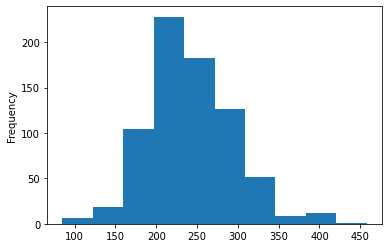

In [67]:
# Como los valores representaban menos del 20% de la data y aún eliminandolos
# tendriamos un volumen considerable para trabajar, aquí se elimina ese grupo
df=df[df['Cholesterol']>70]
df=df[df['Cholesterol']<466]
# Similar para el caso de Oldpeak valores negativos parecen no tener un significado
# médico real por lo que se consideran outliers y se eliminan (son solo 13 datos).
df=df[df['Oldpeak']>=0]
# Revisamos que ahora los datos de cholesterol cumplen una distribucion mas cercana a la normal
df["Cholesterol"].plot.hist()
df.describe()

In [69]:
# Separamos la data en dos grupos disease y no disease y obtenemos valores estadisticos.
disease=df[df["HeartDisease"]==1]
notdisease=df[df["HeartDisease"]==0]
print("Heart disease data \n"  + disease.describe().to_string())
print("\nNo Heart disease data \n"  +notdisease.describe().to_string())

Heart disease data 
              Age         Sex  ChestPainType   RestingBP  Cholesterol  FastingBS  RestingECG       MaxHR  ExerciseAngina     Oldpeak    ST_Slope  HeartDisease
count  351.000000  351.000000     351.000000  351.000000   351.000000  351.00000  351.000000  351.000000      351.000000  351.000000  351.000000         351.0
mean    56.011396    0.886040       0.444444  136.247863   247.210826    0.22792    0.937322  130.495726        0.669516    1.472934    1.037037           1.0
std      8.724343    0.318216       0.872872   18.034842    53.551695    0.42009    0.689971   22.425479        0.471059    1.148033    0.467573           0.0
min     31.000000    0.000000       0.000000   92.000000   100.000000    0.00000    0.000000   71.000000        0.000000    0.000000    0.000000           1.0
25%     50.000000    1.000000       0.000000  124.000000   212.000000    0.00000    0.000000  115.000000        0.000000    0.600000    1.000000           1.0
50%     57.000000    1.000

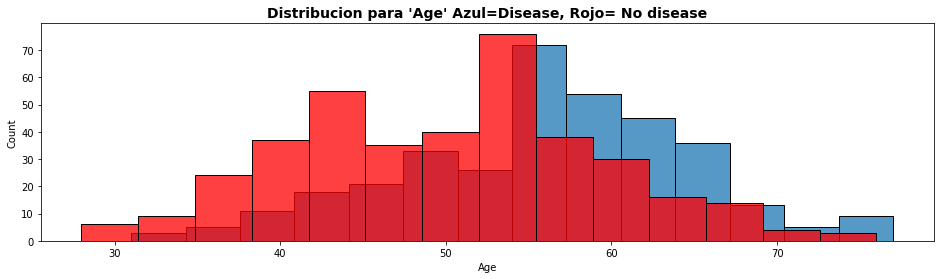

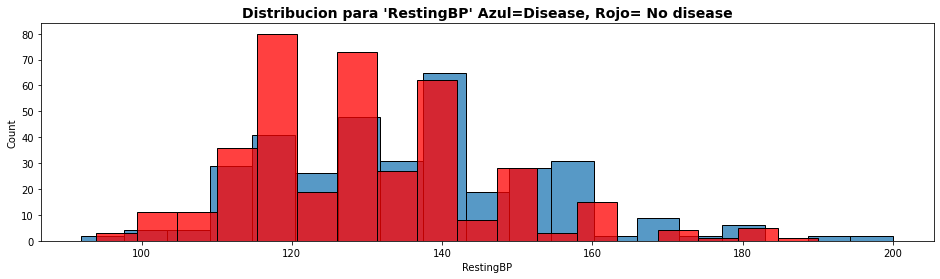

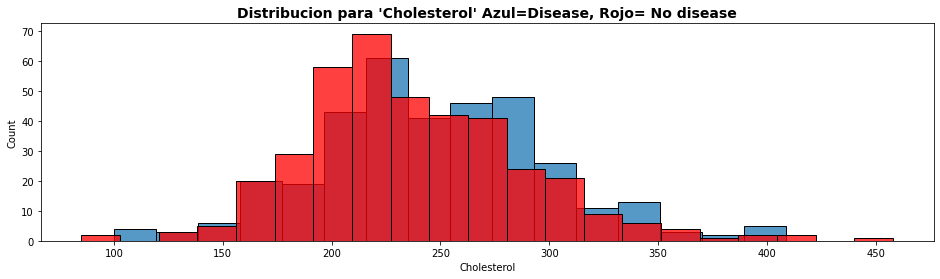

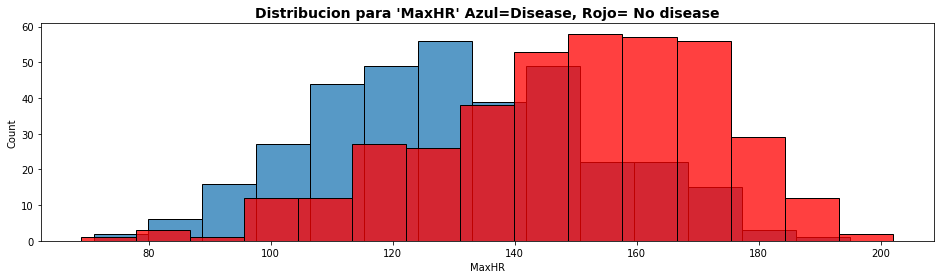

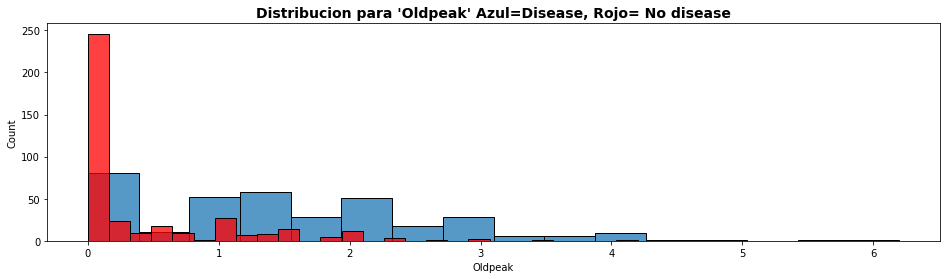

In [70]:
# Se realiza nuevamente visualizaciónes comparando ambos grupos
# Variables cuantitativas
tags=["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
for c in tags:
    plt.figure(figsize=(16,4))
    ax = sns.histplot(disease[c])
    ax = sns.histplot(notdisease[c],color="red")
    ax.set_title(f"Distribucion para '{c}' Azul=Disease, Rojo= No disease",size=14, fontweight='bold')
    plt.show()

In [71]:
# Seleccionamos la data para entrenar el modelo
y=df["HeartDisease"]
x=df[ ["Age","ChestPainType","RestingBP","Cholesterol","FastingBS",            \
       "RestingECG","MaxHR", "Oldpeak","ST_Slope","ExerciseAngina","Sex"] ]
# Nota : Otro grupo de variables que presentaron resultados favorables en 
# el entrenamiento del algoritmo fueron
# ["ChestPainType","MaxHR","ExerciseAngina","ST_Slope","Cholesterol","Oldpeak"]

In [72]:
# Separamos la data en data de entrenamiento y de validacion (test)
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix, precision_score
X_train, X_test, y_train, y_test = tts(x , y, test_size=0.2)

In [73]:
# Train the algorithm
# El procedimiento para optimizar parámetros del modelo se realizó por fuerza bruta
# no se incluye de forma explicita el código aquí, se encontró que un valor
# adecuado para el numero de estimadores era de 200
# En cuanto al criterio del algoritmo se probaron el criterio de entropia y gini
# no encontrando diferencias significativas entre ambos.
model=RFC(n_estimators=200, criterion ="entropy")
model.fit(X_train, y_train)
# Realizamos una predicción
y_pred= model.predict(X_test)
# Realizamos la validación y un plot de la matriz de confusion,
# la diagonal son los valores acertados por la prediccion y la antidiagonal los errores.
matriz= confusion_matrix(y_test, y_pred)
print("\n matriz de confusión\n")
print(matriz)
score= precision_score(y_test,y_pred)
print("\n presicion del modelo \n", score)


 matriz de confusión

[[70  7]
 [12 59]]

 presicion del modelo 
 0.8939393939393939


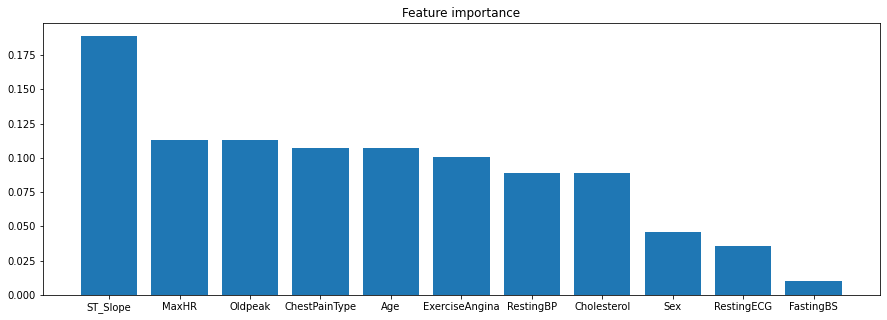

In [82]:
from sklearn.feature_selection import SelectFromModel
import numpy as np

sfm = SelectFromModel(model)
sfm.fit(X_train, y_train)
index = np.argsort(sfm.estimator_.feature_importances_)[::-1]
plt.figure(figsize=(15, 5))
plt.title('Feature importance')
plt.bar(X_train.columns[index], sfm.estimator_.feature_importances_[index])
plt.show()